## Comprehensive Test – Your Final Stretch!

This is a comprehensive test on your TensorBase. The test itself consists of 2 parts.

Instructions:

You do not need to modify any code in this notebook. Simply run each cell in order to complete the test.

If you encounter any errors, please double-check your TensorBase implementation and ensure you have restarted the Jupyter Notebook kernel after making any changes.

Use the “Restart & Run All” option if you want to rerun the entire notebook from scratch.

Good luck!

*Acknowledgement: This notebook is adapted from CS3308 - Machine Learning.*

*We have made some modifications to make it compatible with your TensorBase implementation.*

### Part1 K-means Clustering

In [1]:
import tensor_impl as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
cp.Tensor = cp.TensorBaseImpl

We will use your **clownpiece.TensorBase** to apply K-means to a simple 2D dataset. K-means is an iterative, unsupervised clustering algorithm that groups similar instances into clusters. The algorithm starts by guessing the initial centroids for each cluster, then repeatedly assigns instances to the nearest cluster and recalculates the centroid of each cluster.

**A kind reminder:**

If you make any changes to your TensorBase during testing, **MAKE SURE** to recompile and press the “Restart” button in Jupyter Notebook; otherwise, your modifications will not take effect.

In [2]:
# Load dataset for clustering and visualization
dataset = loadmat('ex1_data/data1.mat')
data = pd.DataFrame(dataset.get('X'), columns=['X1', 'X2'])
data.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


The first part we need to implement is a function that finds the closest centroid for each instance in the dataset.

In [3]:
def find_closest_centroids(X, centroids):
    """
    For each example in X, compute the distance to each centroid
    and assign the example to the closest one.

    Inputs:
        X         : Tensor of shape (m, n), dataset with m examples and n features
        centroids : Tensor of shape (K, n), coordinates of K current centroids

    Output:
        idx       : List of shape (m,), index of the closest centroid (in {0, ..., K-1}) for each example
    """
    (m, n) = X.shape
    K = centroids.shape[0]
    idx = [0] * m  # Initialize index array

    # print("centroids=", centroids)
    for i in range(0, m):
        dist = (centroids - X[i]).pow(2).sum(dim=1, keepdims=False).sqrt()
        min_dist = dist[0]
        for k in range(1, K):
            if dist[k].item() < min_dist.item():
                idx[i] = k
                min_dist = dist[k]
    return idx

Let's test this function to ensure that it works correctly. We will use the test case provided in the exercise.

In [4]:
#  Guess the initial centroids for each cluster
initial_centroids = cp.Tensor([[3, 3], [6, 2], [8, 5]])

# Test the function
X = cp.Tensor(dataset['X'].tolist())
print(X)
idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

Tensor(
  shape=(300, 2), strides=(2, 1)
  data={
    [[1.84208, 4.60757],
     [5.65858, 4.79996],
     [6.35258, 3.29085],
     [2.90402, 4.6122],
     [3.23198, 4.93989],
     [1.24792, 4.93268],
     [1.9762, 4.4349],
     [2.23454, 5.05547],
     [2.98341, 4.84046],
     [2.9797, 4.80671],
     [2.11496, 5.37374],
     [2.1217, 5.20854],
     [1.51435, 4.77003],
     [2.16979, 5.27435],
     [0.418524, 4.88313],
     [2.47054, 4.80419],
     [4.06069, 4.99504],
     [3.00709, 4.67898],
     [0.666323, 4.87188],
     [3.16219, 4.83658],
     [0.511553, 4.91053],
     [3.13428, 4.96178],
     [2.04975, 5.62414],
     [0.665828, 5.24399],
     [1.01732, 4.84474],
     [2.17894, 5.29759],
     [2.85963, 5.26042],
     [1.30883, 5.30159],
     [0.992532, 5.01567],
     [1.40373, 4.57528],
     [2.66047, 5.19624],
     [2.79996, 5.11526],
     [2.06995, 4.68467],
     [3.29765, 5.59206],
     [1.89298, 4.89043],
     [2.55983, 5.26398],
     [1.15354, 4.67867],
     [2.25151, 5.445],
  

[0, 2, 1]

Next, we need a function to compute the centroids of the clusters. A centroid is simply the mean of all the samples currently assigned to that cluster.

In [5]:
def compute_centroids(X, idx, k):
    """
    Given the current assignments of examples to centroids, compute the new
    centroid positions as the mean of the assigned examples.

    Inputs:
        X    : Tensor of shape (m, n), dataset with m examples and n features
        idx  : Tensor of shape (m,), index of the closest centroid for each example
        k    : int, number of clusters

    Output:
        centroids : numpy array of shape (k, n), new centroid coordinates
    """
    idx_cnt = cp.zeros((k,))
    (m, n) = X.shape
    centroids = cp.zeros((k, n))

    for i, id in enumerate(idx):
        idx_cnt[id] += 1
        centroids[id] += X[i]
    
    print(idx_cnt)
    centroids /= (idx_cnt.reshape((-1, 1)))
    return centroids

Let's test this function to ensure that it works correctly.

In [6]:
compute_centroids(X, idx, 3)

Tensor(
  shape=(3), strides=(1)
  data={
    [191, 103, 6]
  }
)



Tensor(
  shape=(3, 2), strides=(2, 1)
  data={
    [[2.4283, 3.15792],
     [5.8135, 2.63366],
     [7.11939, 3.61668]]
  }
)

This output also matches the expected results from the exercise.

The next part involves running the algorithm for several iterations and visualizing the results. Since this step is relatively straightforward, we will build it from scratch. To run the algorithm, we simply need to repeatedly assign each sample to its nearest cluster and then recompute the cluster centroids.

In [7]:
def run_k_means(X, initial_centroids, max_iters):
    """
    Runs the K-means algorithm on data matrix X.

    Inputs:
        X                 : Tensor of shape (m, n), dataset with m examples and n features
        initial_centroids : Tensor of shape (K, n), initial centroids to begin the algorithm
        max_iters         : int, maximum number of iterations to run K-means

    Outputs:
        idx       : Array of shape (m,), final assignment of each example to a centroid
        centroids : Tensor of shape (K, n), final centroid positions after convergence or max_iters
    """
    Ncluster = initial_centroids.shape[0]
    centroids = cp.zeros((Ncluster, X.shape[1]))
    centroids = initial_centroids.clone()
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, Ncluster)
    return (idx, centroids)

In [8]:
idx, centroids = run_k_means(X, initial_centroids, 10)

Tensor(
  shape=(3), strides=(1)
  data={
    [191, 103, 6]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [179, 91, 30]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [164, 88, 48]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [131, 93, 76]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 108, 94]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 102, 100]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 102, 100]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 102, 100]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 102, 100]
  }
)

Tensor(
  shape=(3), strides=(1)
  data={
    [98, 102, 100]
  }
)



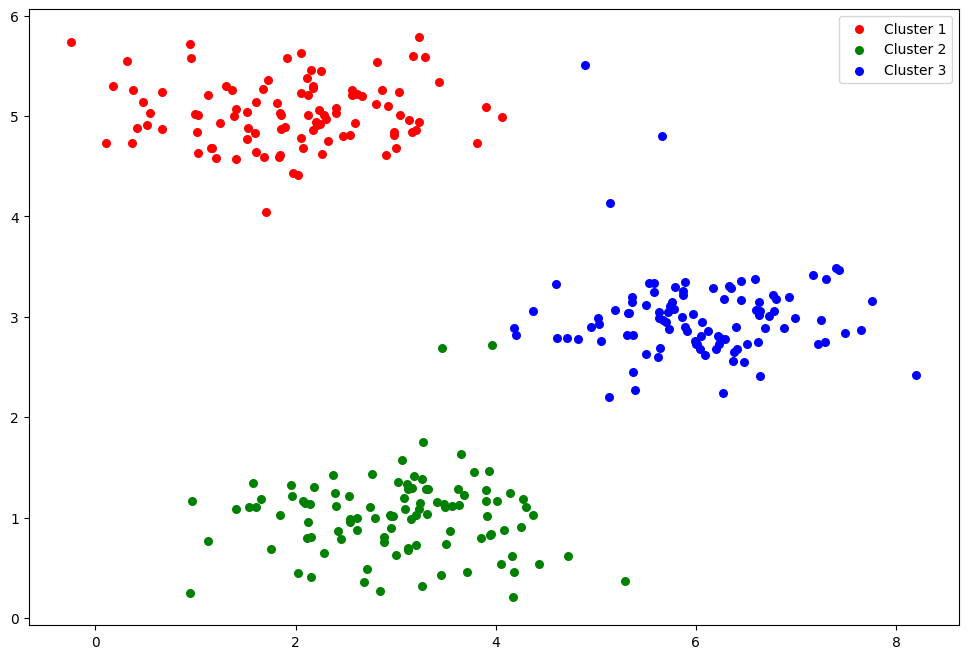

In [9]:
rows1 = []
rows2 = []
rows3 = []
for i in range(len(idx)):
    if idx[i] == 0:
        rows1.append(X[i, :].tolist())
    elif idx[i] == 1:
        rows2.append(X[i, :].tolist())
    elif idx[i] == 2:
        rows3.append(X[i, :].tolist())
        
cluster1 = cp.Tensor(rows1)
cluster2 = cp.Tensor(rows2)
cluster3 = cp.Tensor(rows3)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0].tolist(), cluster1[:,1].tolist(), s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0].tolist(), cluster2[:,1].tolist(), s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0].tolist(), cluster3[:,1].tolist(), s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

### Part2: Planar data classification with a simple neural network

#### 1 - Packages

In [10]:
# Package imports
%pip install scikit-learn
import sys
sys.path.append('./ex2_data')
sys.path.append('./tests/week1/ex2_data')
import tensor_impl as cp
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
cp.Tensor = cp.TensorBaseImpl

%matplotlib inline

# cp.random.seed(1) # set a seed so that the results are consistent

Note: you may need to restart the kernel to use updated packages.


#### 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [11]:
X, Y = load_planar_dataset()
X = cp.Tensor(X.tolist())
Y = cp.Tensor(Y.tolist())

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

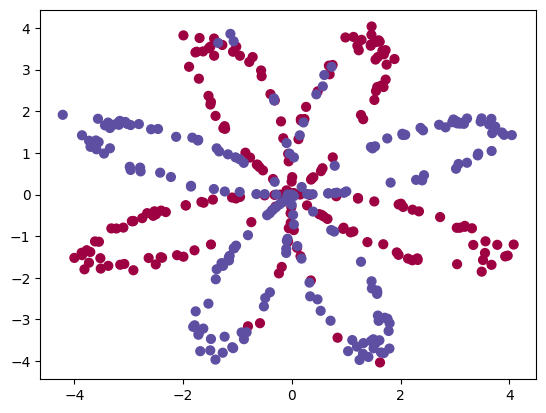

In [12]:
# Visualize the data:
plt.scatter(X[0, :].tolist(), X[1, :].tolist(), c=Y.tolist(), s=40, cmap=plt.cm.Spectral);

You have:
    
    - a Tensor (matrix) X that contains your features (x1, x2)
    
    - a Tensor (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

In [13]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: [2, 400]
The shape of Y is: [1, 400]
I have m = 400 training examples!


#### 3 - Neural Network model

You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="./ex2_data/images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$
y^{(i)}_{\text{prediction}} =
\begin{cases}
1 & \text{if } a^{[2](i)} > 0.5 \\
0 & \text{otherwise}
\end{cases} \tag{5}
$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


#### 3.1 - Defining the neural network structure ####

Define three variables:

    - n_x: the size of the input layer

    - n_h: the size of the hidden layer (set this to 4) 

    - n_y: the size of the output layer


In [14]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

In [15]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output**  
*(These are not the sizes you will use for your network, they are just used to assess the function you've just coded).*

| Variable | Value |
|----------|-------|
| **n_x**  | 5     |
| **n_h**  | 4     |
| **n_y**  | 2     |


#### 3.2 - Initialize the model's parameters ####

Implement the function `initialize_parameters()`.

In [16]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    W1 = cp.randn((n_h, n_x)) * 0.01
    b1 = cp.zeros((n_h, 1))
    W2 = cp.randn((n_y, n_h)) * 0.01
    b2 = cp.zeros((n_y, 1))
    
    assert (W1.shape == [n_h, n_x])
    assert (b1.shape == [n_h, 1])
    assert (W2.shape == [n_y, n_h])
    assert (b2.shape == [n_y, 1])
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [17]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = Tensor(
  shape=(4, 2), strides=(2, 1)
  data={
    [[-0.00297882, -0.0065858],
     [-0.0130612, -0.0139355],
     [-0.00317174, 0.00663842],
     [-0.00492953, -0.0134599]]
  }
)

b1 = Tensor(
  shape=(4, 1), strides=(1, 1)
  data={
    [[0],
     [0],
     [0],
     [0]]
  }
)

W2 = Tensor(
  shape=(1, 4), strides=(4, 1)
  data={
    [[0.00633337, 0.00666475, 0.00208008, 0.000396104]]
  }
)

b2 = Tensor(
  shape=(1, 1), strides=(1, 1)
  data={
    [[0]]
  }
)



#### 3.3 - The Loop ####

Implement `forward_propagation()`.

In [18]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = cp.Tensor(parameters["W1"].tolist())
    b1 = cp.Tensor(parameters["b1"].tolist())
    W2 = cp.Tensor(parameters["W2"].tolist())
    b2 = cp.Tensor(parameters["b2"].tolist())
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = cp.dot(W1, X) + b1
    A1 = cp.tanh(Z1) 
    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == [1, X.shape[1]])
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [19]:
X_assess, parameters = forward_propagation_test_case()
X_assess = cp.Tensor(X_assess.tolist())
A2, cache = forward_propagation(X_assess, parameters)

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

Implement `compute_cost()` to compute the value of the cost $J$. Try not to use a for loop.

In [20]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = (cp.log(A2) * Y) + (cp.log(1 - A2) * (1 - Y))
    cost = - logprobs.sum(dim = 1) / m
    
    cost = float(cost.item())   # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [21]:
A2, Y_assess, parameters = compute_cost_test_case()
A2 = cp.Tensor(A2.tolist())

Y_assess = cp.Tensor(Y_assess.tolist())

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587887763977


Using the cache computed during forward propagation, we can now implement backward propagation.

Implement the function `backward_propagation()`.

In [22]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- 0/1 labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = cp.Tensor(parameters["W1"].tolist())
    W2 = cp.Tensor(parameters["W2"].tolist())
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cp.Tensor(cache["A1"].tolist())
    A2 = cp.Tensor(cache["A2"].tolist())
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = cp.dot(dZ2, A1.T) / m
    db2 = cp.sum(dZ2, dim=1, keepdims=True) / m
    dZ1 = cp.dot(W2.T, dZ2) * (1 - cp.pow(A1, 2))  # Derivative of tanh is (1 - A1^2)
    dW1 = cp.dot(dZ1, X.T) / m
    db1 = cp.sum(dZ1, dim=1, keepdims=True) / m
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [23]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
X_assess = cp.Tensor(X_assess.tolist())
Y_assess = cp.Tensor(Y_assess.tolist())

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = Tensor(
  shape=(4, 2), strides=(2, 1)
  data={
    [[0.00301023, -0.00747267],
     [0.00257968, -0.00641288],
     [-0.00156892, 0.003893],
     [-0.00652037, 0.0161824]]
  }
)

db1 = Tensor(
  shape=(4, 1), strides=(1, 1)
  data={
    [[0.00176201],
     [0.00150995],
     [-0.000917363],
     [-0.00381422]]
  }
)

dW2 = Tensor(
  shape=(1, 4), strides=(4, 1)
  data={
    [[0.000788406, 0.0176543, -0.000841659, -0.0102253]]
  }
)

db2 = Tensor(
  shape=(1, 1), strides=(1, 1)
  data={
    [[-0.166557]]
  }
)



In [24]:
## test
parameters, grads = update_parameters_test_case()

In [25]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = cp.Tensor(parameters["W1"].tolist())
    b1 = cp.Tensor(parameters["b1"].tolist())
    W2 = cp.Tensor(parameters["W2"].tolist())
    b2 = cp.Tensor(parameters["b2"].tolist())
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = cp.Tensor(grads["dW1"].tolist())
    db1 = cp.Tensor(grads["db1"].tolist())
    dW2 = cp.Tensor(grads["dW2"].tolist())
    db2 = cp.Tensor(grads["db2"].tolist())
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [26]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = Tensor(
  shape=(4, 2), strides=(2, 1)
  data={
    [[-0.00643025, 0.0193672],
     [-0.0241046, 0.0397805],
     [-0.0165397, -0.0209618],
     [0.0104686, -0.0599014]]
  }
)

b1 = Tensor(
  shape=(4, 1), strides=(1, 1)
  data={
    [[-1.02421e-06],
     [1.27374e-05],
     [8.32997e-07],
     [-3.20137e-06]]
  }
)

W2 = Tensor(
  shape=(1, 4), strides=(4, 1)
  data={
    [[-0.0104108, -0.0446328, 0.0175803, 0.0474711]]
  }
)

b2 = Tensor(
  shape=(1, 1), strides=(1, 1)
  data={
    [[0.000104566]]
  }
)



#### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

In [27]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return parameters

In [28]:
X_assess, Y_assess = nn_model_test_case()
X_assess = cp.Tensor(X_assess.tolist())
Y_assess = cp.Tensor(Y_assess.tolist())
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.693088
Cost after iteration 1000: 0.000226
Cost after iteration 2000: 0.000110
Cost after iteration 3000: 0.000073
Cost after iteration 4000: 0.000054
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000036
Cost after iteration 7000: 0.000031
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = Tensor(
  shape=(4, 2), strides=(2, 1)
  data={
    [[0.81429, -1.49779],
     [0.502012, -0.949963],
     [-0.661903, 1.23332],
     [0.755235, -1.37886]]
  }
)

b1 = Tensor(
  shape=(4, 1), strides=(1, 1)
  data={
    [[-0.390595],
     [-0.186792],
     [0.295002],
     [-0.349824]]
  }
)

W2 = Tensor(
  shape=(1, 4), strides=(4, 1)
  data={
    [[3.84813, 1.54805, -2.50915, 3.20289]]
  }
)

b2 = Tensor(
  shape=(1, 1), strides=(1, 1)
  data={
    [[0.208962]]
  }
)



### 4.5 Predictions

Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [29]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    X = cp.Tensor(X.tolist())
    A2, cache = forward_propagation(X, parameters)
    A2 = cp.Tensor(A2.tolist())
    predictions = (A2 > cp.Tensor((A2.shape[0],), 0.5))
    ### END CODE HERE ###
    
    return predictions

In [30]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions= " + str(predictions))

predictions= Tensor(
  shape=(1, 3), strides=(3, 1)
  data={
    [[1, 0, 1]]
  }
)



It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693209


Cost after iteration 1000: 0.288943
Cost after iteration 2000: 0.276646
Cost after iteration 3000: 0.268974
Cost after iteration 4000: 0.263591
Cost after iteration 5000: 0.259979
Cost after iteration 6000: 0.257436
Cost after iteration 7000: 0.255539
Cost after iteration 8000: 0.254062
Cost after iteration 9000: 0.252870


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

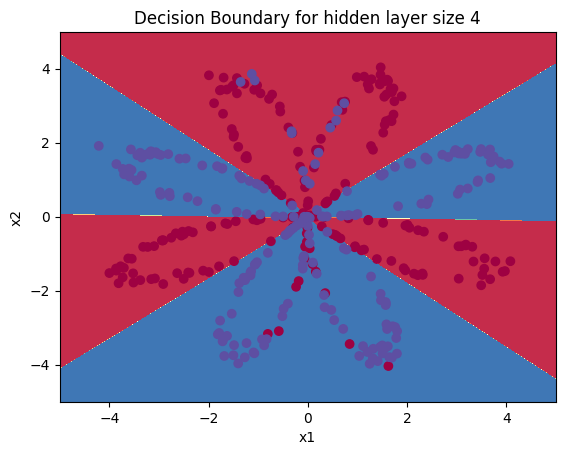

In [31]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [32]:
# Print accuracy
predictions = predict(parameters, X)
print("Correctly predicted = " + str((cp.dot(Y, predictions.T) + cp.dot(1 - Y, 1 - predictions.T)).item()))
print("Number of points=", Y.shape[1])
print ('Accuracy: %f' % float(100 * ((cp.dot(Y,predictions.T) + cp.dot(1-Y,1-predictions.T)).item()/(float(Y.shape[1])))) + '%')

Correctly predicted = 364.0
Number of points= 400
Accuracy: 91.000000%


### If your Acc is greater than 90%, then Congrats! You have survived **Clownpiece Torch Week 1**🥳🥳